<a href="https://colab.research.google.com/github/rohitamar/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

    def reparam(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn_like(sigma)
        return mu + eps * sigma

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.mu(x), self.logvar(x)
        z = self.reparam(mu, logvar)
        x_r = self.decode(z)
        return x_r, mu, logvar

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 21.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]


In [ ]:
from torch.optim import Adam

def train_model(model, dataloader, config):
    epochs = config['epochs']
    optimizer = Adam(model.parameters(), lr=1e-3)

    avg_losses = []
    avg_recons = []
    avg_kls = []

    model = model.to(device)
    for epoch in range(epochs):
        avg_loss = avg_recon = avg_kl = 0.0
        iters = 0
        for step, data in enumerate(dataloader):
            input, _ = data
            input = input.to(device)
            input = input.reshape(-1, 28 * 28)
            batch_size = input.size(0)

            preds, mu, logvar = model(input)

            recon = F.binary_cross_entropy(preds, input, reduction='sum') / batch_size
            kl = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1), dim=0)
            loss = recon + kl

            avg_loss += loss.item()
            avg_recon += recon.item()
            avg_kl += kl.item()
            iters += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss /= iters
        avg_recon /= iters
        avg_kl /= iters

        print(f"Epoch {epoch} - Recon: {avg_recon} KL: {avg_kl} Both: {avg_loss}")
        avg_losses.append(avg_loss)
        avg_recons.append(avg_recon)
        avg_kls.append(avg_kl)

    return avg_losses, avg_recons, avg_kls

In [ ]:
model = VAE(20)

loss, recon, kl = train_model(model, train_loader, {
    'epochs': 20
})

Epoch 0 - Recon: 123.08679392903646 KL: 18.947254929240543 Both: 142.03404872639973
Epoch 1 - Recon: 91.74091439208985 KL: 23.856773708089193 Both: 115.5976880045573
Epoch 2 - Recon: 87.32564247233073 KL: 24.608385490926107 Both: 111.9340279703776
Epoch 3 - Recon: 85.36986841634115 KL: 24.845771859741212 Both: 110.21564022623699
Epoch 4 - Recon: 84.1483648844401 KL: 25.00095746561686 Both: 109.1493223063151
Epoch 5 - Recon: 83.33370202636719 KL: 25.059785252888997 Both: 108.39348733317057
Epoch 6 - Recon: 82.76928914388021 KL: 25.077696626790363 Both: 107.84698573404948
Epoch 7 - Recon: 82.28235761311849 KL: 25.138492826334634 Both: 107.42085039876302
Epoch 8 - Recon: 81.88051941731771 KL: 25.133125505574544 Both: 107.01364494628906
Epoch 9 - Recon: 81.58387318115234 KL: 25.19961509399414 Both: 106.78348832600912
Epoch 10 - Recon: 81.26939151204427 KL: 25.13982044881185 Both: 106.40921190999349
Epoch 11 - Recon: 81.04208509114584 KL: 25.174611888631183 Both: 106.21669702555339
Epoch 12

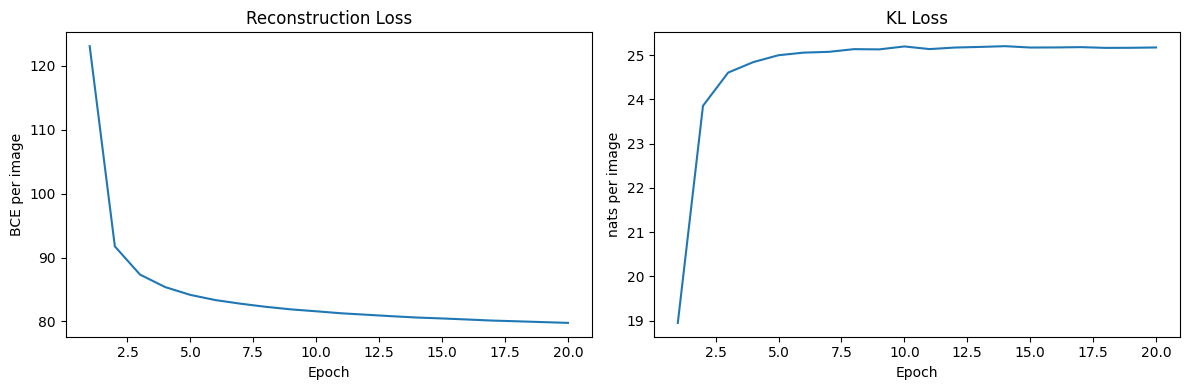

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(1, len(recon) + 1), recon)
axes[0].set_title("Reconstruction Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("BCE per image")

axes[1].plot(range(1, len(kl) + 1), kl)
axes[1].set_title("KL Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("nats per image")

plt.tight_layout()
plt.show()

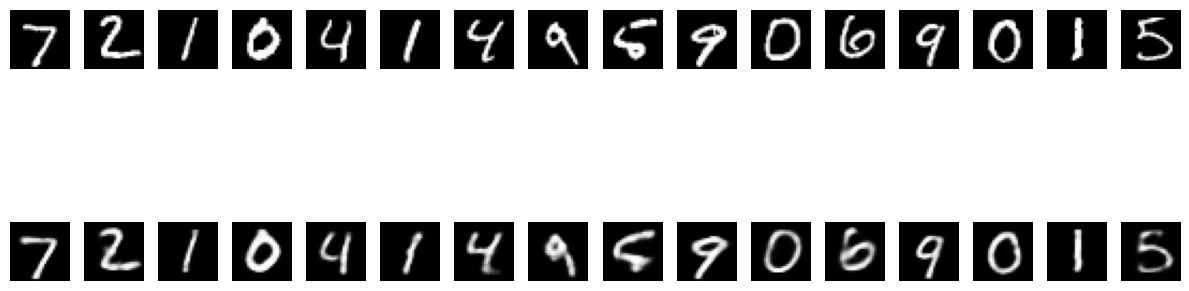

In [ ]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device).view(-1, 28 * 28)
    recon, _, _ = model(x)

plt.figure(figsize=(12,6))
for i in range(16):
    plt.subplot(2, 16, i + 1)
    plt.imshow(x[i].cpu().view(28, 28), cmap="gray")
    plt.axis("off")

    plt.subplot(2, 16, i + 17)
    plt.imshow(recon[i].cpu().view(28, 28), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

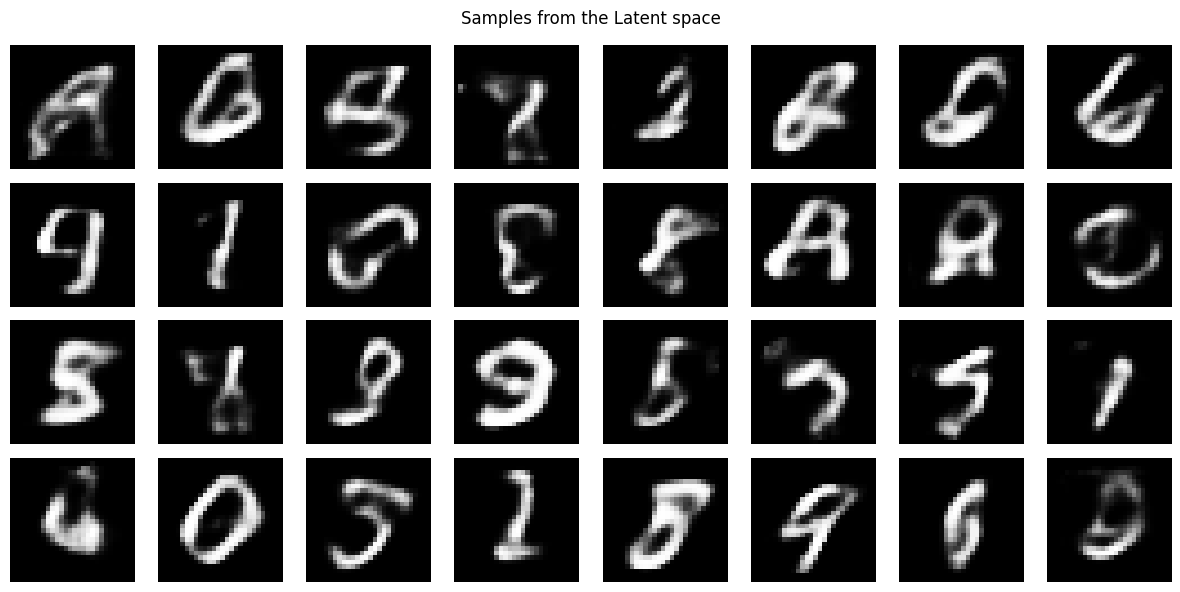

In [ ]:
z = torch.randn(32, 20, device=device)
with torch.no_grad():
    samples = model.decoder(z)

plt.figure(figsize=(12, 6))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(samples[i].cpu().view(28, 28), cmap="gray")
    plt.axis("off")
plt.suptitle("Samples from the Latent space")
plt.tight_layout()
plt.show()